In [1]:
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np

### Initial conditions

In [2]:
skills = {1:{'p':0.1, 'v':240}, 
          2:{'p':0.2, 'v':120}, 
          3:{'p':0.3, 'v':80}, 
          4:{'p':0.4, 'v':60}, 
          5:{'p':0.5, 'v':48},
          6:{'p':0.6, 'v':40}}

In [3]:
expected_unskilled = 1
for key in skills:
    expected_unskilled *= (1-skills[key]['p'])
print("expected number of unskilled persons in a sample of 100 is", 100*expected_unskilled)

expected number of unskilled persons in a sample of 100 is 6.048000000000001


### Simulating network

Note: money is in $ 1000

In [343]:
def initial_wealth_distribution():
    return max(0,np.random.randn()*10+10)
def initial_payroll():
    #mean = $50,000/12 ≈ $4,150, sd = $20,000/12 ≈ $1,650
    return min(max(0,np.random.randn()*1.65+4.15), 17)
def initial_capital():
    return max(0,np.random.randn()*165+415)
cost_of_living = 0.85

In [344]:
def initiate(num_people, num_companies):
    G = nx.Graph()
    n = num_people + num_companies
    G.add_nodes_from(np.arange(0,n))
    people_index = np.arange(0,num_people)
    company_index = np.arange(num_people,n)
    P = [{"money": initial_wealth_distribution(), 
          "skills":[skill for skill in skills 
                    if np.random.random() < skills[skill]['p']],
          "jobs": [],
          "salary": 0,
          "job_offers":{}} for i in range(num_people)]
    C = [{"utility": initial_capital(), "payroll": initial_payroll(), "employees":[], "applications":[]} 
         for i in range(num_companies)]
    return G, P, C, people_index, company_index

In [345]:
def marginal_contribution_of_employee(c, v):
    return np.sqrt((C[c]["utility"])**2+v) - C[c]["utility"]

In [407]:
def hire(c, v):
    #print(marginal_contribution_of_employee(c, v), c)
    if marginal_contribution_of_employee(c, v) > 0.25: #task: decide the criteria
        return 1
    return 0

In [408]:
def leisure_vs_consumption():
    leisure = np.random.random()
    consumption = 1 - leisure
    return leisure, consumption

In [460]:
def evolve(G, P, C, people_index, company_index, tax_rate):
    
    values = np.zeros(num_people)
    
    for person in people_index:
        values[person] = sum([skills[i]['v'] for i in P[person]['skills']])
        leisure, consumption = leisure_vs_consumption()
        money = P[person]["money"]
        salary = P[person]["salary"]
        
        #the person looks for a job
        if P[person]['jobs'] != [] or money + salary <= cost_of_living:
            for company in company_index:
                company_arg = company - num_people
                #if the person needs a job to pay the costs of living, then he must apply for it
                if money - cost_of_living <= 0 and tax_rate<1:
                    C[company_arg]['applications'].append(person)
                #person considers the tax rate while weighing tradeoffs
                elif np.log(np.exp(money) + C[company_arg]["payroll"] * values[person]/100)*(1-tax_rate) > 0.1: #task: decide the criteria
                    C[company_arg]['applications'].append(person)
                    
                #task: consider the decrease in incentive to work due to redistribution
                    
        elif money > cost_of_living:
            if leisure > consumption:
                for job in P[person]['jobs']:   
                    edge = (job, person)
                    G.remove_edge(*edge)
                    
                P[person]['jobs'] = []
                P[person]['salary'] = 0
        
    #companies consider applicants
    for company in company_index:
        company_arg = company - num_people
        for applicant in C[company_arg]["applications"]:
            if hire(company_arg, values[applicant]):
                P[applicant]['job_offers'][company] = C[company_arg]["payroll"] * values[applicant]/100 #salaries do not mention taxes
        
        #print(C[company_arg]["applications"])      
        C[company_arg]["applications"] = []
   
    government_revenue = 0

    #person accepts or rejects job offers
    for person in people_index:
        job_offers = P[person]['job_offers']
        #print(job_offers)
        best_offer  = 0
        best_provider = None
        
        if job_offers != {}:
            for offer in job_offers:
                if job_offers[offer] > best_offer:
                    best_offer = job_offers[offer]
                    best_provider = offer
            
            #we assume if a person already has a job he has to drop it for accepting a new job
            for job in P[person]['jobs']:
                edge = (job, person)
                G.remove_edge(*edge)
            
            P[person]['jobs'] = [best_provider]
            P[person]['salary'] = best_offer
        
            edge = (best_provider, person)
            G.add_edge(*edge)
        
            P[person]['job_offers'] = {}
        
        P[person]['money'] += P[person]['salary']*(1-tax_rate)
        #task: subtract money from companies after incorporating profit mechanism
        
        government_revenue += P[person]['salary']*tax_rate
        
        #subtract cost of living
        P[person]["money"] -= cost_of_living
        
    for person in people_index:
        P[person]['money'] += government_revenue/num_people
    
    return G

In [522]:
num_people = 1000
num_companies = 100

G, P, C, people_index, company_index = initiate(num_people, num_companies)

In [523]:
for i in range(100):
    G = evolve(G, P, C, people_index, company_index, tax_rate=0.2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning:

overflow encountered in exp



In [524]:
#print("Nodes of graph: ")
#print(G.nodes())
#print("Edges of graph: ")
#print(G.edges())

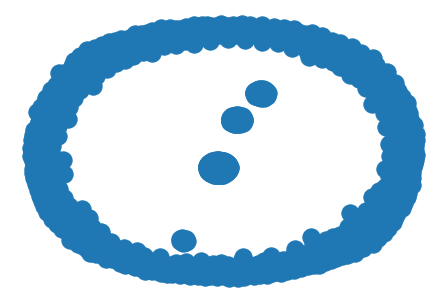

In [525]:
nx.draw(G)
plt.show()

In [526]:
#P

In [527]:
wealth = [P[i]['money'] for i in range(len(P))]

In [536]:
def distribute(values):
    k = 1000
    values = np.array(values)
    max_value = max(values)
    min_value = min(values)
    bin_size = (max_value - min_value)/k
    distribution = np.zeros(k+1)
    for value in values:
        distribution[int(value/bin_size)] += 1
    return distribution

In [537]:
distribute(wealth)

array([126., 140., 107., ...,   1.,   0.,   9.])

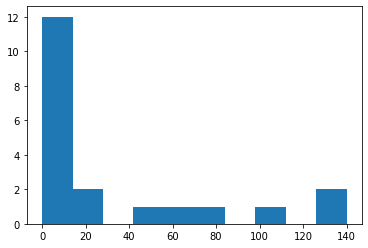

In [546]:
plt.hist(distribute(wealth)[:20])
plt.savefig("tax=0.2.jpg")
plt.show()